# Preparation

In [1]:
# mounting notebook with my google drive environment 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Imports, functions

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

dataset_path = '/content/drive/My Drive/NLP/dataset/'
print('Datasets:')
!dir "/content/drive/My Drive/NLP/dataset"

def evaluate_model(y_true, predictions):
  cm = confusion_matrix(y_true, predictions)
  print("\nConfusion matrix: \n", cm)
  print("")
  cr = classification_report(y_true, predictions)
  print("Classification report: \n", cr)
  print("")
  sns.heatmap(cm, annot=True)
  plt.show()

Datasets:
rt-polarity.neg  rt-polarity.pos


### Data

In [0]:
def load_data():
  # reading files into dataframes
  pos = pd.read_csv(dataset_path + 'rt-polarity.pos', sep='\t', header=None, names=['Sentiment'])
  neg = pd.read_csv(dataset_path + 'rt-polarity.neg', sep='\t', header=None, names=['Sentiment'])
  pos['Target'] = 1
  neg['Target'] = 0

  # creating one X dataframe
  X_full = pd.concat((pos, neg), axis=0, ignore_index=True)
  X_full = shuffle(X_full)

  # splitting data into training and testing parts
  X_train, X_test, y_train, y_test = train_test_split(X_full['Sentiment'].values,
                                                      X_full['Target'].values,
                                                      random_state=0,
                                                      test_size=0.2)
  return X_full, X_train, X_test, y_train, y_test

### Data vectorization

In [0]:
# vectorize tokenized examples
def vectorizer(X_train, X_test):
  vect = TfidfVectorizer(use_idf=True)
  X_train_tfidf = vect.fit_transform(X_train)
  X_test_tfidf = vect.transform(X_test)
  return X_train_tfidf, X_test_tfidf

# loading data
X_full, X_train, X_test, y_train, y_test = load_data()

# vectorized training and testing examples
X_train_vec, X_test_vec = vectorizer(X_train, X_test)

# Naive Bayes

## Sklearn

### Functions

In [0]:
# grid search model to find optimal hyperparameters
def nb_model(alpha):
  grid={"alpha": alpha}
  nb_model = MultinomialNB()
  model = GridSearchCV(nb_model, grid,cv=5)
  return model

### Model

In [6]:
# creating and training a model
start_time = time.time()
model = nb_model(np.linspace(0.1,5, 10))
model.fit(X_train_vec, y_train)
pred_nb = model.predict(X_test_vec)
print('Execution time: {}'.format(time.time() - start_time))

Execution time: 0.2579948902130127


### Evaluation

In [0]:
# creating confusion matrix and classification report
cm_nb = confusion_matrix(y_test, pred_nb)
cr_nb = classification_report(y_test, pred_nb)

Best parameters are: {'alpha': 1.7333333333333336}
Accuracy: 77.59409074920858 %

Confusion matrix: 
 [[832 233]
 [248 820]]

Classification report: 
               precision    recall  f1-score   support

           0       0.77      0.78      0.78      1065
           1       0.78      0.77      0.77      1068

    accuracy                           0.77      2133
   macro avg       0.77      0.77      0.77      2133
weighted avg       0.77      0.77      0.77      2133




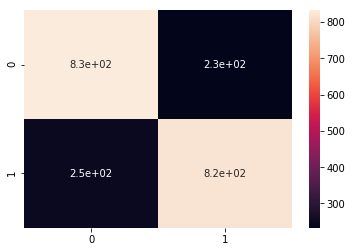

In [8]:
# best parameters
print('Best parameters are: {}'.format(model.best_params_))
# accuracy
print('Accuracy: {} %'.format(model.best_score_*100))
# confusion matrix, classification report
evaluate_model(y_test, pred_nb)

### Execution time for models comparison

In [9]:
start_log = time.time()
model = LogisticRegression(C=4, penalty='l2')
model.fit(X_train_vec, y_train)
acc = model.score(X_test_vec, y_test)
print('Execution time: {}s'.format(time.time() - start_log))

Execution time: 0.07679104804992676s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## From scratch

### Functions

In [0]:
# Calculate Naive Bayes algorithm parameters
def calculations(X, y):
  p = X[y==1].sum(0) + 1
  q = X[y==0].sum(0) + 1
  r = np.log((p/p.sum())/(q/q.sum()))
  b = np.log(len(p) / len(q))
  return r, b

# Predict targets of given matrix using learned parameters
def predict_Bayes(X, r, b):
  pre_preds = X @ r.T + b
  predictions= pre_preds.T > 0
  return predictions

# Calculate our predictions accuracy
def accuracy(y_true, predictions):
  accuracy = (predictions == y_true).mean()*100
  return accuracy

### Model

In [11]:
start_time = time.time()
# calculating Naive Bayes model parameters
r, b = calculations(X_train_vec, y_train)

# predicting test data targets
pred_nb_sc = predict_Bayes(X_test_vec, r, b)

# calculating our model accuracy
accuracy = accuracy(pred_nb_sc, y_test)
print('Execution time: {}s'.format(time.time() - start_time))

Execution time: 0.005614519119262695s


### Evaluation

Test accuracy: 77.44960150023441

Confusion matrix: 
 [[831 234]
 [247 821]]

Classification report: 
               precision    recall  f1-score   support

           0       0.77      0.78      0.78      1065
           1       0.78      0.77      0.77      1068

    accuracy                           0.77      2133
   macro avg       0.77      0.77      0.77      2133
weighted avg       0.77      0.77      0.77      2133




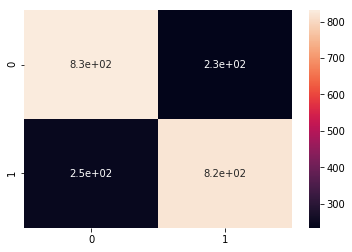

In [12]:
# printing accuracy
print('Test accuracy: {}'.format(accuracy))

# model evaluation (confusion matrix, heatmap)
evaluate_model(y_test, pred_nb_sc.T)

# Logistic regression

### Functions

In [0]:
# grid search model to find optimal hyperparameters
def loregr_model(C_range, penalties):
  grid={"C": C_range, "penalty": penalties}
  logreg = LogisticRegression()
  model = GridSearchCV(logreg, grid,cv=2)
  return model

### Model

In [14]:
# creating and training a model
start_time = time.time()
model = loregr_model(np.linspace(1,10,10), ["l1","l2"])
model.fit(X_train_vec, y_train)
pred_lg = model.predict(X_test_vec)
print('Execution time: {}'.format(time.time() - start_time))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Execution time: 2.4189679622650146


### Evaluation

In [0]:
# creating confusion matrix and classification report
cm_lg = confusion_matrix(y_test, pred_lg)
cr_lg = classification_report(y_test, pred_lg)

Best parameters are: {'C': 7.0, 'penalty': 'l2'}
Accuracy: 74.49876890608512 %

Confusion matrix: 
 [[832 233]
 [248 820]]

Classification report: 
               precision    recall  f1-score   support

           0       0.77      0.78      0.78      1065
           1       0.78      0.77      0.77      1068

    accuracy                           0.77      2133
   macro avg       0.77      0.77      0.77      2133
weighted avg       0.77      0.77      0.77      2133




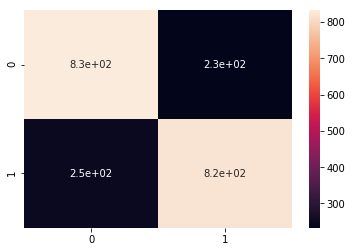

In [16]:
# best parameters
print('Best parameters are: {}'.format(model.best_params_))
# accuracy
print('Accuracy: {} %'.format(model.best_score_*100))
# confusion matrix, classification report
evaluate_model(y_test, pred_nb)

### Execution time for models comparison

In [17]:
start_log = time.time()
model = LogisticRegression(C=4, penalty='l2')
model.fit(X_train_vec, y_train)
acc = model.score(X_test_vec, y_test)
print('Execution time: {}s'.format(time.time() - start_log))

Execution time: 0.07988595962524414s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
